# Libraries

In [79]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import kstest
from arch import arch_model

# Upload Data

To demonstrate the methodology's functionality, we will procure financial data from Yahoo Finance utilizing the 'yfinance' Python library. It's noteworthy to mention that while Yahoo Finance offers accessibility and ease, there are potential limitations inherent to this data source. Financial data from Yahoo Finance may sometimes experience slight delays, lack granularity, or might not always reflect the most up-to-date adjustments from exchanges. Even marginal data discrepancies can have significant implications on trading outcomes.

* **SPY**: The SPDR S&P 500 ETF Trust (SPY) is one of the most widely traded ETFs in the world. It seeks to provide investment results that correspond to the price and yield performance of the S&P 500 Index.

* **EWG**: The iShares MSCI Germany ETF (EWG) is an exchange-traded fund that tracks the investment results of the MSCI Germany Index. Composed of large and mid-sized companies in Germany.

It would be insightful to look at the performance and interrelation of these financial instruments since the developmental paths of US and European economies started to differ signficantly in the recent years.

In [36]:
SPY = yf.download("SPY", start="2015-01-01", end="2019-11-01")
EWG = yf.download("EWG", start="2015-01-01", end="2019-11-01")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


# Round the Prices

Utilizing this methodology to retrieve data from Yahoo Finance, we acknowledge the potential for minor discrepancies in the exactness of the prices. We will standardize the data by rounding to two decimal places. For the purpose of this analysis and to maintain consistency, these rounded values will be treated as the definitive prices.

In [37]:
SPY.iloc[:,:5] = np.round(SPY.iloc[:,:5], 2)
EWG.iloc[:,:5] = np.round(EWG.iloc[:,:5], 2)

# Plot Prices

Next, we'll display the evolutions of price series of both stocks side by side for easier comparison.

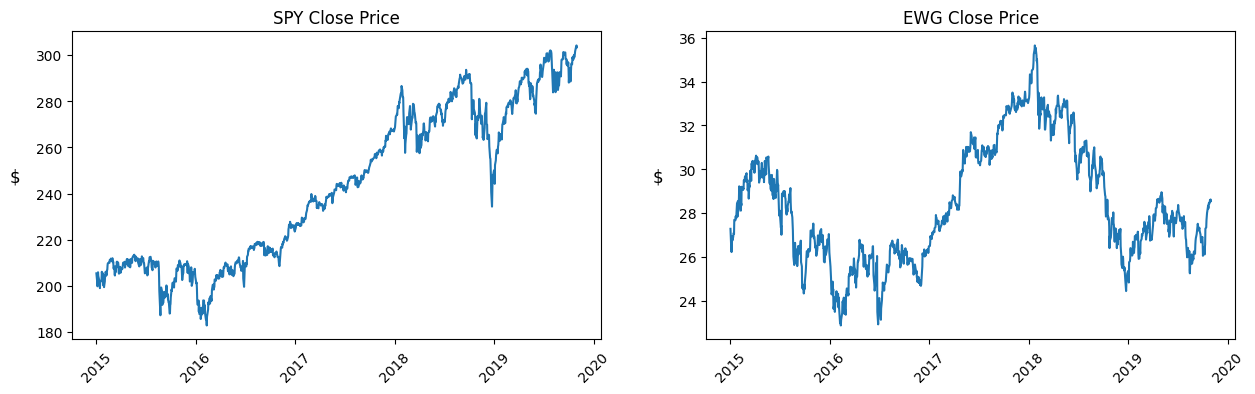

In [38]:
# Create 2 side-by-side graphs
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

# Plot AMZN
axs[0].plot(SPY.Close)
axs[0].set_title("SPY Close Price")
axs[0].set_ylabel("$", rotation=0, fontsize=12, labelpad=15)
axs[0].tick_params("x", labelrotation=45)

# Plot BIIB
axs[1].plot(EWG.Close)
axs[1].set_title("EWG Close Price")
axs[1].set_ylabel("$", rotation=0, fontsize=12, labelpad=15)
axs[1].tick_params("x", labelrotation=45)

# Check for Missing Data

In [51]:
print(
    "SPY: \n" +
    f"{np.sum(SPY.isna())}"
)

print(
    "\n" +
    "EWH: \n" +
    f"{np.sum(EWG.isna())}"
)

SPY: 
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Return        0
Log_Return    0
dtype: int64

EWH: 
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Return        0
Log_Return    0
dtype: int64


# Calculate Returns

In [40]:
SPY["Return"] = (SPY.Close - SPY.Close.shift(1)) / SPY.Close.shift(1)
EWG["Return"] = (EWG.Close - EWG.Close.shift(1)) / EWG.Close.shift(1)

# Check Lengths

In [41]:
len_SPY, len_EWH = len(SPY), len(EWG)

if len_SPY == len_EWH:
    len_message = f"The data sets each contains {len_SPY} observations."
else:
    len_message = "The observations across the data sets vary in number."

print(len_message)

The data sets each contains 1217 observations.


# Basic Statistics

In [42]:
char_message = (
    f"SPY mean return: {np.round(np.mean(SPY.Return) * 100, 4)}%.\n"
    f"EWH mean return: {np.round(np.mean(EWG.Return) * 100, 4)}%.\n"
    f"SPY std of returns: {np.round(np.std(SPY.Return) * 100, 4)}%.\n"
    f"EWH std of returns: {np.round(np.std(EWG.Return) * 100, 4)}%.\n"
    f"Correlation of returns: {np.corrcoef(SPY.Return[1:], EWG.Return[1:])[0,1]}."
)

print(char_message)

SPY mean return: 0.0358%.
EWH mean return: 0.0101%.
SPY std of returns: 0.8614%.
EWH std of returns: 1.1223%.
Correlation of returns: 0.7369844079439368.


# Logarithmic Returns

After we observed some facts about our financial data, we will actually switch to logarithmic returns. Logarithmic returns have a number of convenient properties:

* Time Additivity – total return over two consequitive time periods is just the sum of corresponding logarithmic returns.
* Symmetry – a 10% loss following a 10% gain will result in the return to the initial value.
* Stability of Variance
* Closer to Normal Distribution – while taking logarithms does not guarantee normality, log returns tend to be more normally distributed, which makes certain assumptions more valid.

In [43]:
# Calculate log returns first
SPY["Log_Return"] = np.log(SPY.Close / SPY.Close.shift(1))
EWG["Log_Return"] = np.log(EWG.Close / EWG.Close.shift(1))

# Then delete the first observation
SPY.dropna(inplace=True)
EWG.dropna(inplace=True)

# Plot Log Returns

Here, we will display side-by-side graphs of daily logarithmic returns for both stocks.

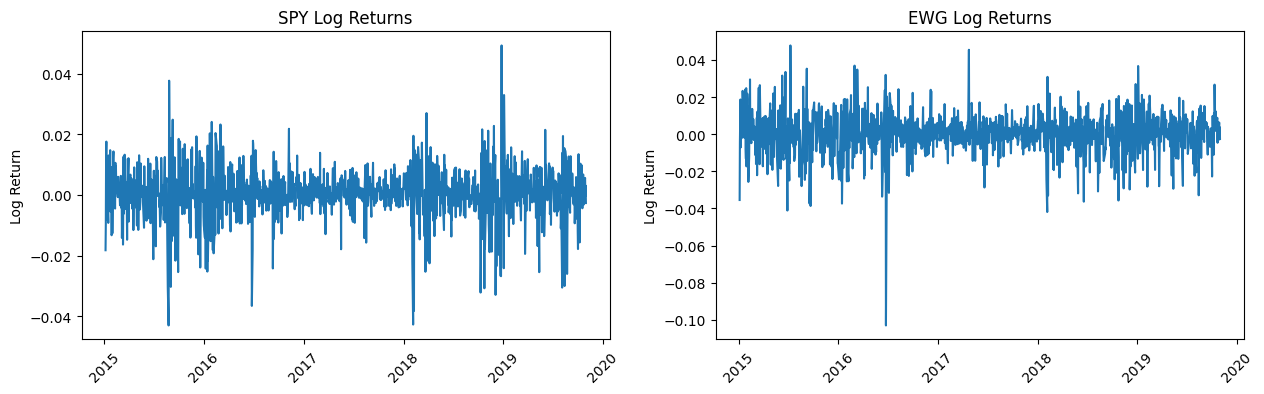

In [44]:
# Create 2 side-by-side graphs
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

# Plot AMZN
axs[0].plot(SPY.Log_Return)
axs[0].set_title("SPY Log Returns")
axs[0].set_ylabel("Log Return", fontsize=10)
axs[0].tick_params("x", labelrotation=45)

# Plot BIIB
axs[1].plot(EWG.Log_Return)
axs[1].set_title("EWG Log Returns")
axs[1].set_ylabel("Log Return", fontsize=10)
axs[1].tick_params("x", labelrotation=45)

# Statistical Tests

## Augmented Dickey-Fuller Test

The Augmented Dickey-Fuller (ADF) test is a statistical test to check whether a given time series is stationary or not. $H_0$ is that time series has a unit root (i.e. is not stationary). Within the ambit of time series econometrics, the non-stationarity of a series, especially one with a unit root, can lead to spurious regression results, thereby undermining the credibility and interpretability of empirical analyses.  More on ADF test: https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test.

In [45]:
# Convert to pandas series
spy_ts = pd.Series(SPY.Log_Return)
ewg_ts = pd.Series(EWG.Log_Return)

# Run the test
spy_adf_result = adfuller(spy_ts)
ewg_adf_result = adfuller(ewg_ts)

adfuller_message = (
    "ADF Statistic: \n" +
    " " * 16 + f"SPY: {spy_adf_result[0]}\n" +
    " " * 16 + f"EWG: {ewg_adf_result[0]}\n" +
    "p-value: \n" +
    " " * 16 + f"SPY: {spy_adf_result[1]}\n" +
    " " * 16 + f"EWG: {ewg_adf_result[1]}\n"
)

print(adfuller_message)

ADF Statistic: 
                SPY: -26.36882695047492
                EWG: -36.50967695860096
p-value: 
                SPY: 0.0
                EWG: 0.0



**Conclusions:**

Since p-values are less than $0.01$, we reject $H_0$ and indicate that both financial series are stationary at 1% significance level.

## Engle’s Langarange Multiplier Test for Autoregressive Conditional Heteroscedasticity

Next we will conduct Engle's LM ARCH testing. It is a statistical method used to test for the presence of heteroscedasticity (i.e. non-constant variance) in the residuals of a time series model.

* $H_0$: No ARCH effects are present.
* $H_1$: ARCH effects are present.

In [46]:
spy_arch_result = het_arch(spy_ts, nlags=1)
ewg_arch_result = het_arch(ewg_ts, nlags=1)

arch_message = (
    "LM Statistic: \n" +
    " " * 16 + f"SPY: {spy_arch_result[0]}\n" +
    " " * 16 + f"EWG: {ewg_arch_result[0]}\n" +
    "p-value: \n" +
    " " * 16 + f"SPY: {spy_arch_result[1]}\n" +
    " " * 16 + f"EWG: {ewg_arch_result[1]}"
)

print(arch_message)

LM Statistic: 
                SPY: 90.10764829258456
                EWG: 15.320234845705947
p-value: 
                SPY: 2.2554812315806093e-21
                EWG: 9.073933466653152e-05


**Conclusions:**

Since p-values are less than $0.01$, we reject $H_0$ and indicate that there exist a presence of ARCH effects in both financial series at 1% significance level.

## Kolmogorov-Smirnov Test

The Kolmogorov-Smirnov test is a non-parametric statistical test used to compare a sample distribution with a reference probability distribution. It is useful for determining if a sample follows a specific distribution (such as the Normal distribution).

* $H_0$: The data follows a specified (Normal) distribution.
* $H_1$: The data does not follow a specified (Normal) distribution.

In [47]:
# Calculate means
spy_mean = np.mean(spy_ts)
ewg_mean = np.mean(ewg_ts)

# Calculate standard deviations
spy_std = np.std(spy_ts)
ewg_std = np.std(ewg_ts)

# Conduct KS test
spy_ks_result = kstest(spy_ts, "norm", args=(spy_mean, spy_std))
ewg_ks_result = kstest(ewg_ts, "norm", args=(ewg_mean, ewg_std))

ks_message = (
    "KS Statistic: \n" +
    " " * 16 + f"SPY: {spy_ks_result[0]}\n" +
    " " * 16 + f"EWG: {ewg_ks_result[0]}\n" +
    "p-value: \n" +
    " " * 16 + f"SPY: {spy_ks_result[1]}\n" +
    " " * 16 + f"EWG: {ewg_ks_result[1]}"
)

print(ks_message)

KS Statistic: 
                SPY: 0.10319145860973677
                EWG: 0.06843553041287229
p-value: 
                SPY: 9.985969967456953e-12
                EWG: 2.1393591724003956e-05


**Conclusions:**

Since p-values are less than $0.01$, we reject $H_0$ and indicate that both distributions differ from Normal at 1% significance level. Combining all of the conclusions above, all of these speak in favor of using conditional heteroscedasticity model in making inference about our financial data.

# Estimation of Univariate Time Series Models.

Financial returns often exhibit fat tails as could be seen from the graphs above. Therefore, for the further modelling we will choose Student's t-distribution. We could also choose from the variety of heavy- or fat-tailed distributions such as Levy, Pareto, Lognormal, etc. However, Student's t-distribution is convineitly integrated in most of statistics packages and, hence, relatively easy to use. What is more, as for now, we are dealing with daily returns, so some of other distributions will be too fat-tailed for the modelling purposes.

Our choice of model will be GARCH(1,1). There exist a lot of papers regarding the effectiveness of GARCH(1,1) model in comparison with other conditional heterscedasticity models. It is relativaly fast-trained and integrated in most statistical packages across different platforms.

Let's start with the estimating parameters of the GARCH(1,1) model for the logarithmic returns of SPY.

In [75]:
# GARCH(1,1) model with Student's t-distribution
spy_model = arch_model(spy_ts, vol="Garch", p=1, q=1, dist="t", rescale=False)

# Fit the model without printing optimization result (disp="off")
spy_garch_results = spy_model.fit(disp="off")

print(spy_garch_results.params)

mu          0.000725
omega       0.000002
alpha[1]    0.199038
beta[1]     0.789307
nu          4.961019
Name: params, dtype: float64


Similarly, estimate the parameters of the GARCH(1,1) model for EWG.

In [76]:
ewg_model = arch_model(ewg_ts, vol="Garch", p=1, q=1, dist="t", rescale=False)
ewg_garch_results = ewg_model.fit(disp="off")
print(ewg_garch_results.params)

mu           0.000164
omega        0.000507
alpha[1]     0.409406
beta[1]      0.529116
nu          17.825875
Name: params, dtype: float64


Let's proceed to the evaluation of the models specified above. In the standardized residuals of the model, there should be no ARCH effects and autocorrelation, and the theoretical distribution of standardized innovations should match the empirical distribution of the model residuals.

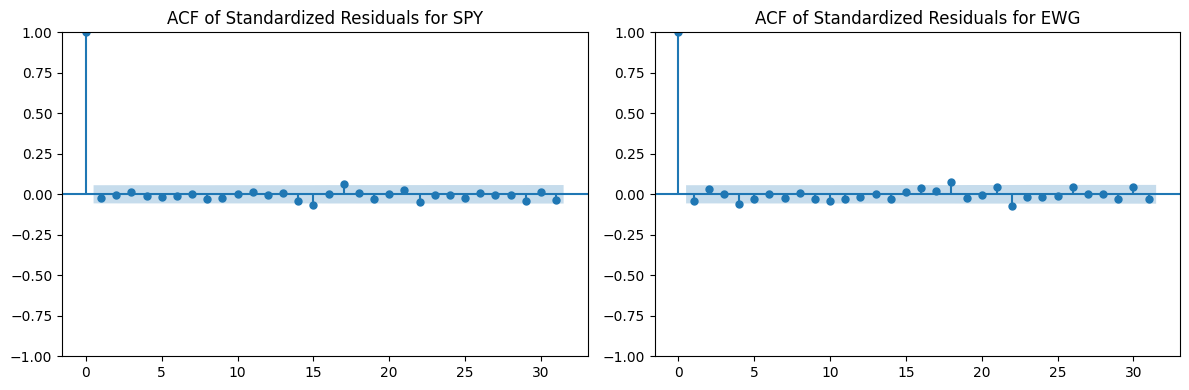

In [89]:
# Compute standardized residuals for SPY
spy_resid = spy_garch_results.resid / spy_garch_results.conditional_volatility

# Compute standardized residuals for EWG
ewg_resid = ewg_garch_results.resid / ewg_garch_results.conditional_volatility

# Plot ACFs
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(spy_resid, ax=ax[0], title="ACF of Standardized Residuals for SPY")
plot_acf(ewg_resid, ax=ax[1], title="ACF of Standardized Residuals for EWG")
plt.tight_layout()

From these plots, we can see that autocorrelation is eliminated from the standardized residuals. Let's also test for the presence of ARCH effects and normality of standardized residuals of the models.

In [103]:
import re 

s = "."
print(re.match("[a-z]", s))

None
